In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

In [3]:
with pm.Model() as pooled:
    mu = pm.Normal("mu", 0, sigma=1e6)
    
    obs = pm.Normal("obs", mu, sigma=sigma, observed=y)
    
    trace_p = pm.sample(2000)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

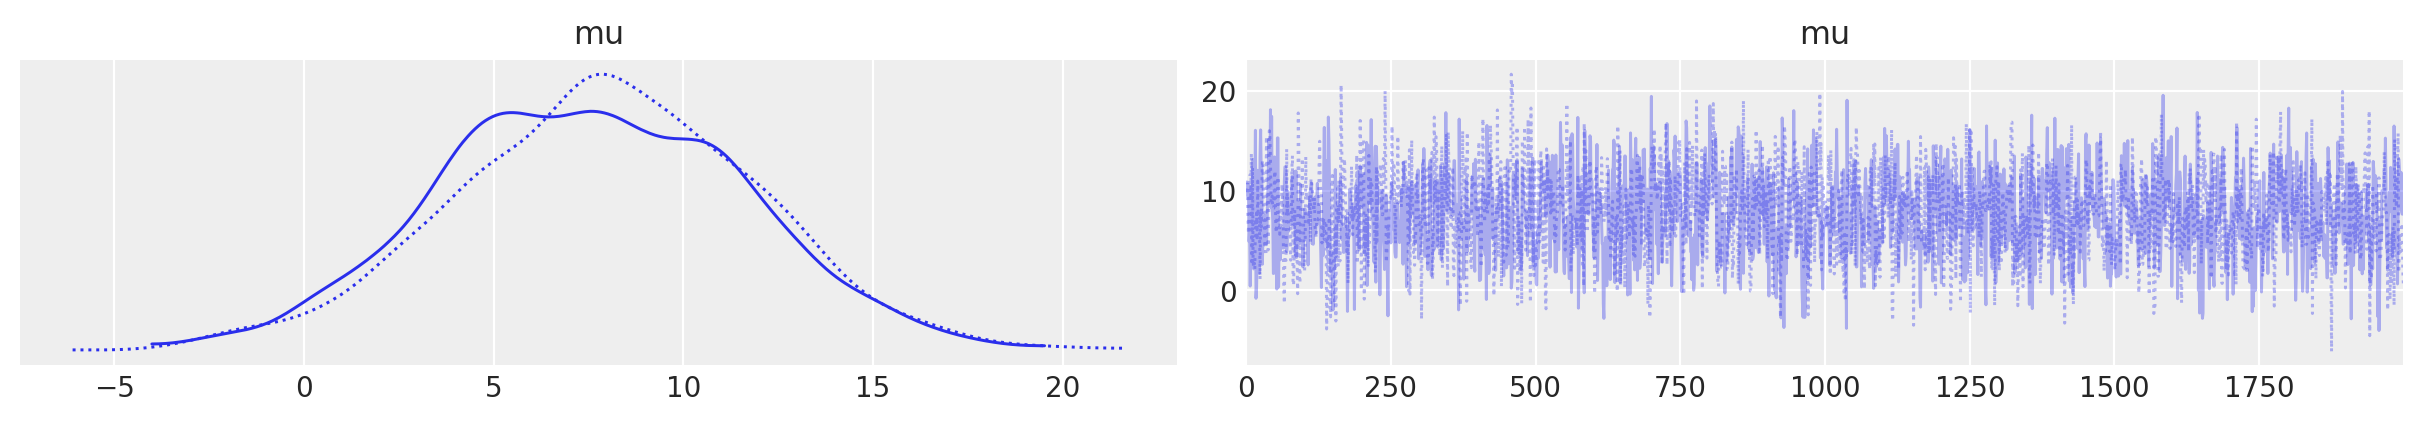

In [4]:
az.plot_trace(trace_p)

In [7]:
with pm.Model() as hierarchical:
    eta = pm.Normal("eta", 0,1 , shape=J)
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)
    
    theta = pm.Deterministic("theta", mu + tau*eta)
    
    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)
    
    trace_h = pm.sample(2000, target_accept=0.9)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

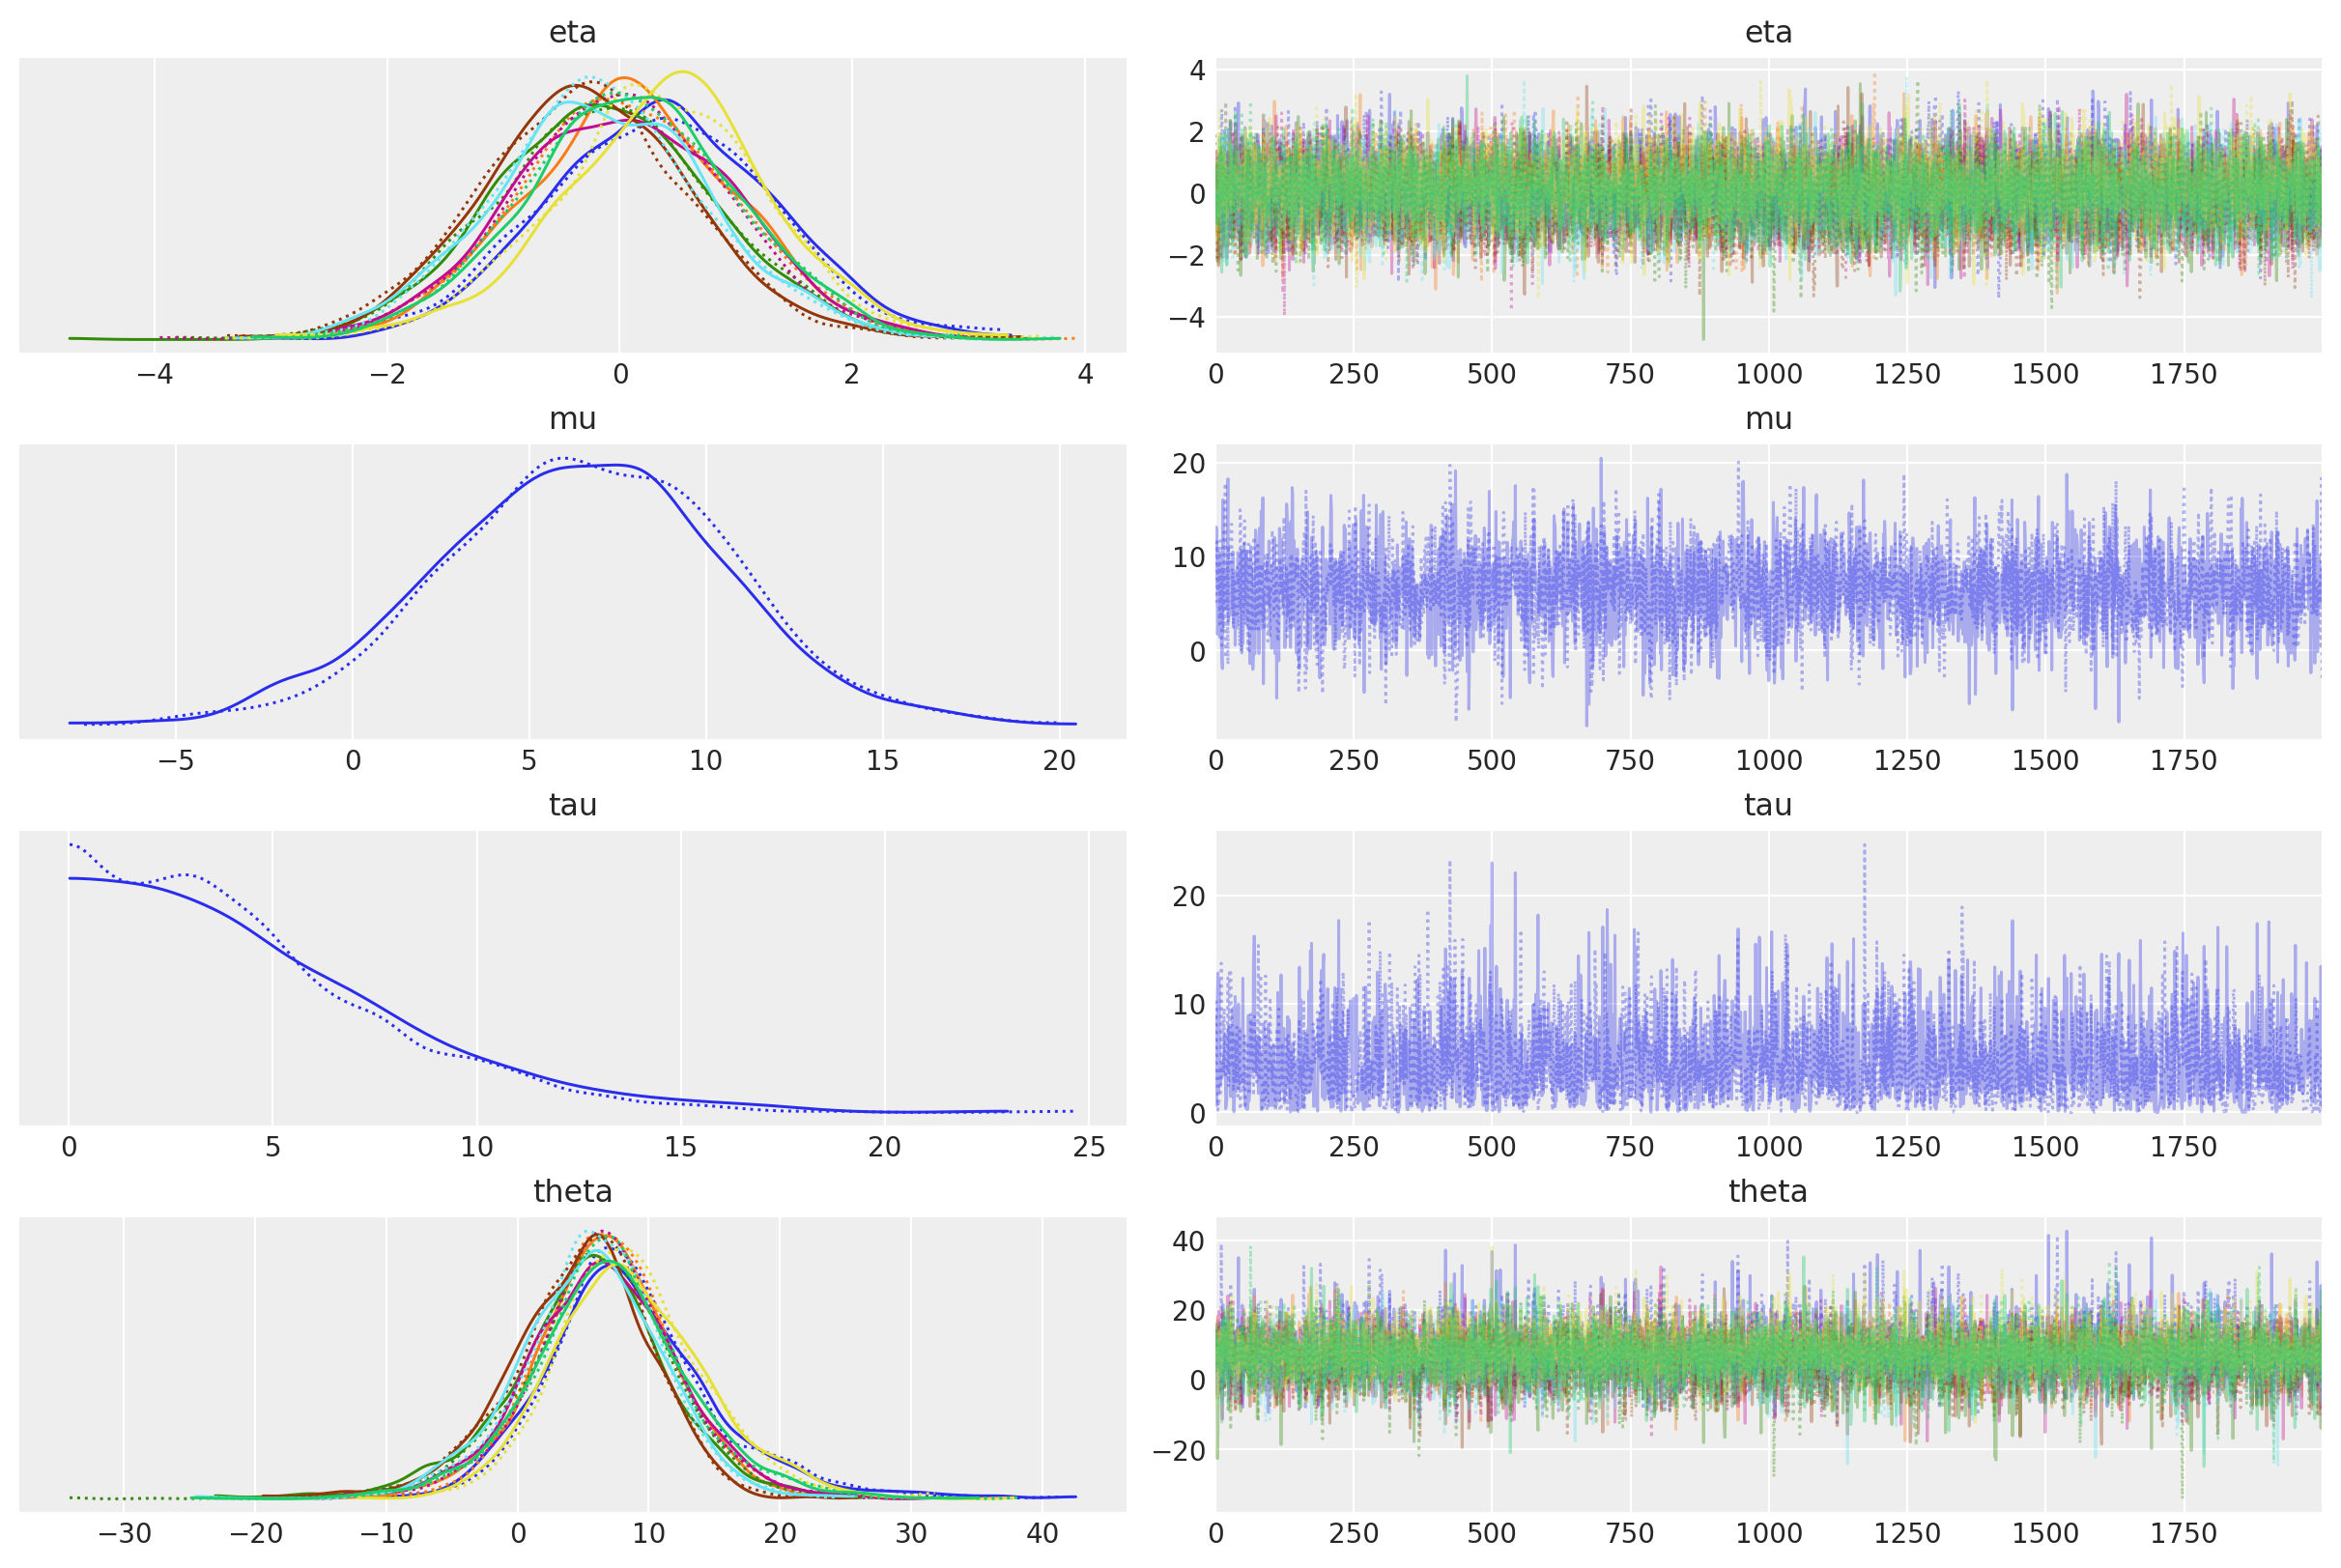

In [9]:
az.plot_trace(trace_h)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

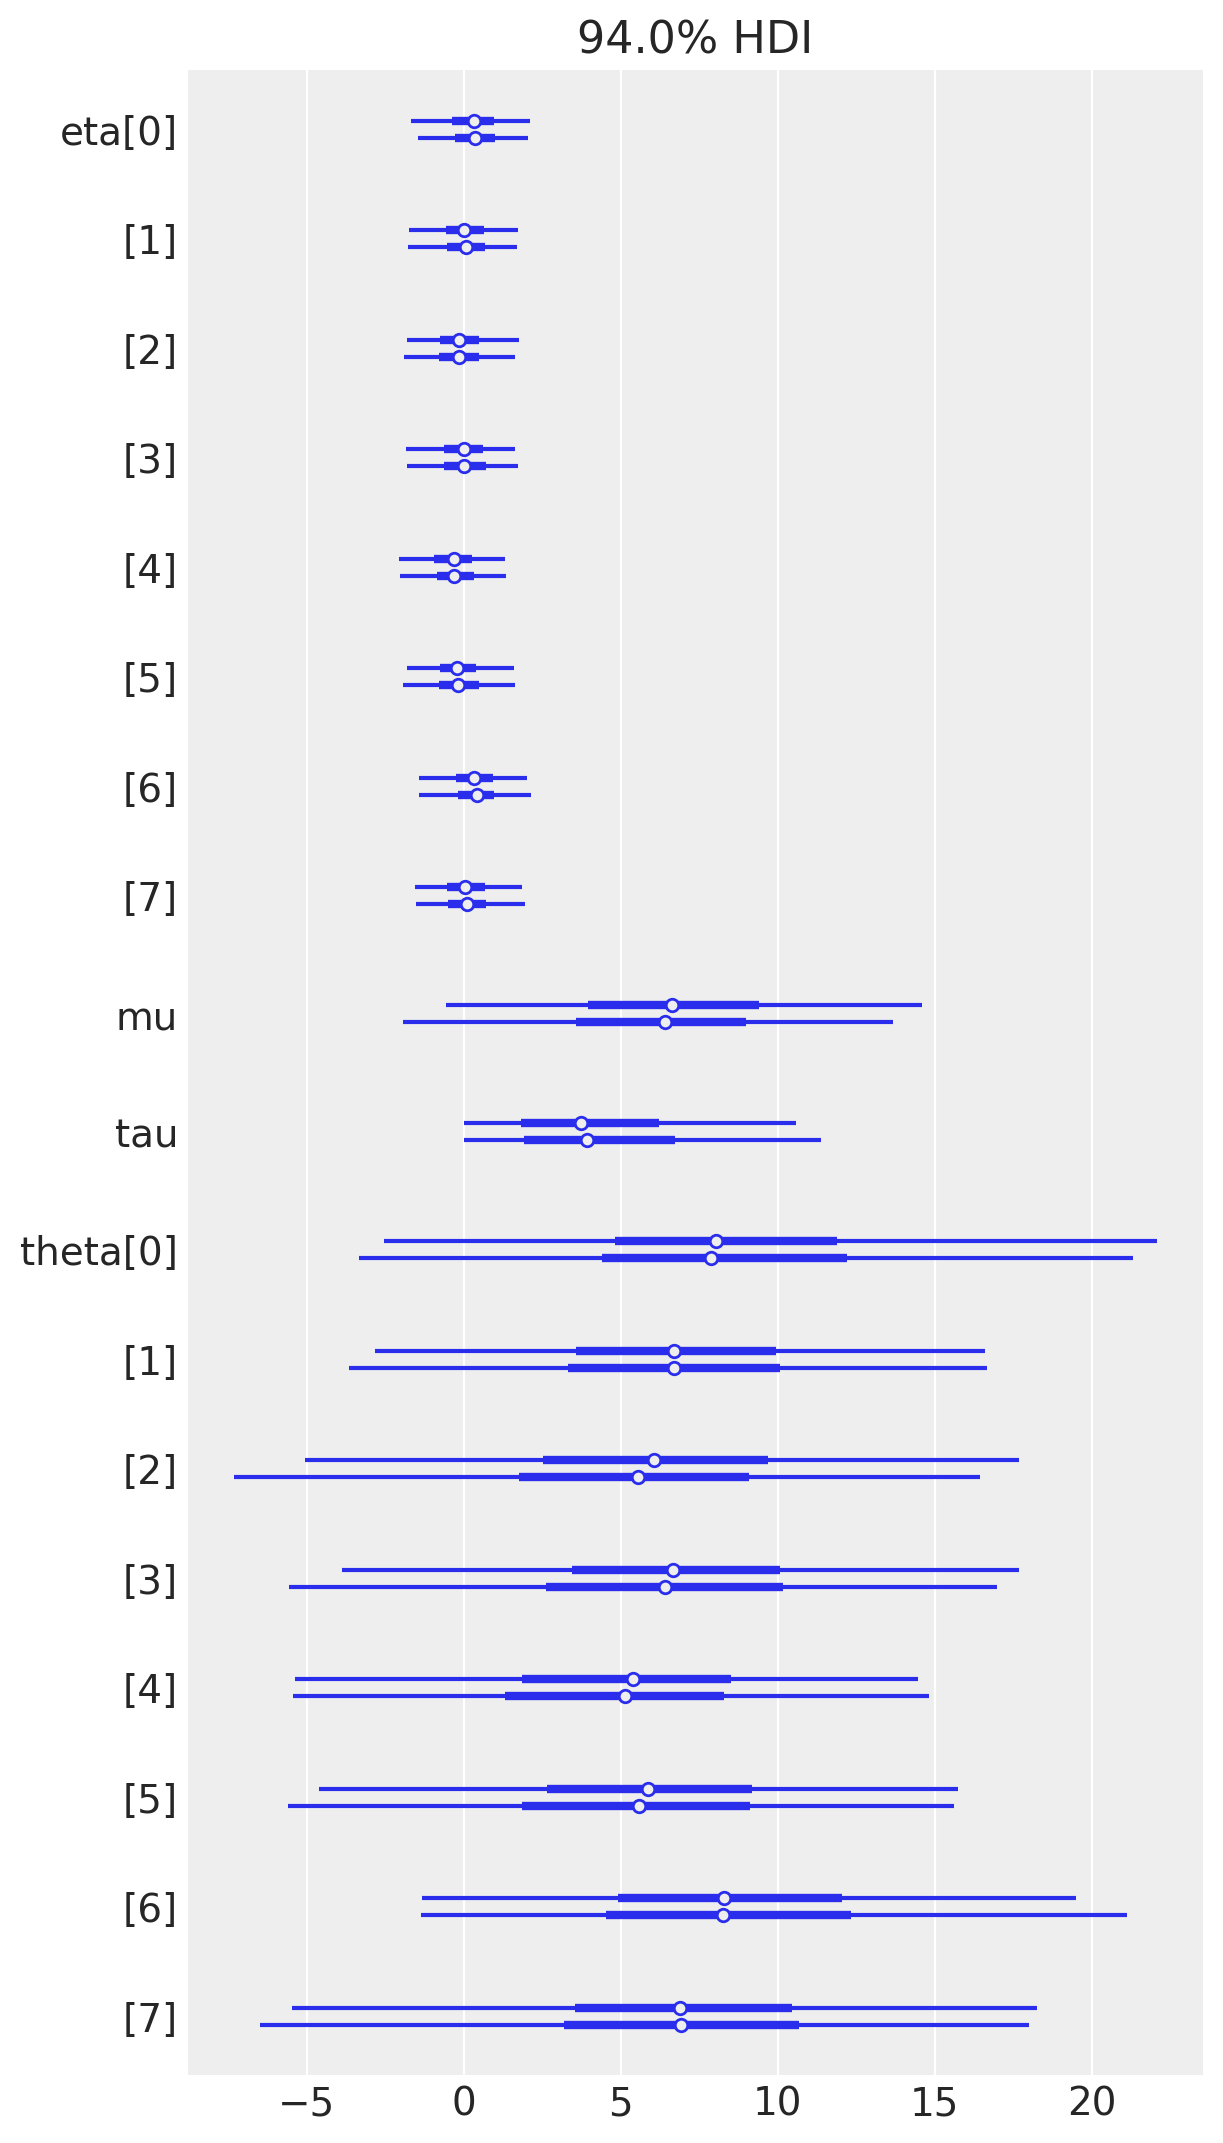

In [10]:
az.plot_forest(trace_h)

In [11]:
with pooled:
    pm.compute_log_likelihood(trace_p)

In [13]:
pooled_loo = az.loo(trace_p)

In [15]:
with hierarchical:
    pm.compute_log_likelihood(trace_h)

hierarchical_loo = az.loo(trace_h)
hierarchical_loo

Computed from 4000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.70     1.10
p_loo        1.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        4   50.0%
 (0.5, 0.7]   (ok)          4   50.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [17]:
df_comp_loo = az.compare({
    "hierarchical":trace_h,
    "pooled": trace_p
})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.536419,0.654500,0.000000,1.0,1.101789,0.000000,False,log
hierarchical,1,-30.702691,1.063825,0.166271,0.0,1.096804,0.241466,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

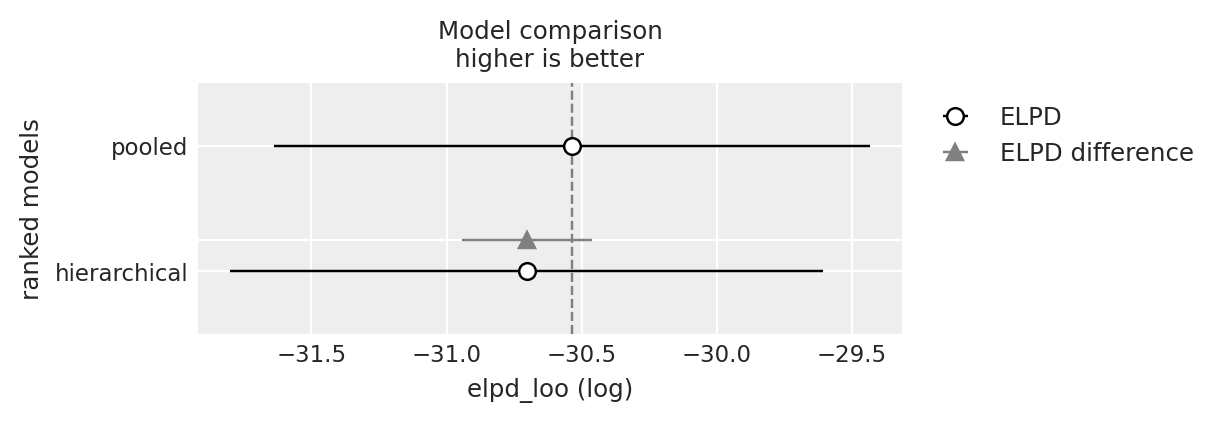

In [18]:
az.plot_compare(df_comp_loo, insample_dev=False)